In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:

def estimate_memory_usage(model, input_size, optimizer):
    # 모델을 GPU로 옮기기
    model = model.cuda()
    model.train()  # 모델을 학습 모드로 설정

    # 모델 가중치 메모리 계산
    total_weights_memory = sum(p.element_size() * p.nelement() for p in model.parameters())

    # 더미 입력 데이터 생성
    inputs = torch.randn(input_size).cuda()

    # 활성화 메모리 계산을 위한 훅 등록
    activations = []
    def save_activation(name):
        def hook(model, input, output):
            activations.append(output.element_size() * output.nelement())
        return hook

    for name, layer in model.named_modules():
        layer.register_forward_hook(save_activation(name))

    # 순전파 실행
    outputs = model(inputs)

    # 손실 계산 및 역전파 준비
    criterion = nn.MSELoss()
    labels = torch.randn(outputs.shape).cuda()
    loss = criterion(outputs, labels)
    loss.backward()

    # 기울기 메모리 계산
    gradients_memory = sum(p.grad.element_size() * p.grad.nelement() for p in model.parameters() if p.grad is not None)

    # 옵티마이저 상태 메모리 계산을 위해 step 실행
    optimizer.step()

    # 옵티마이저 상태 메모리 계산
    optimizer_state_memory = 0
    for state in optimizer.state.values():
        for k, v in state.items():
            if torch.is_tensor(v):
                optimizer_state_memory += v.element_size() * v.nelement()

    # 메모리 사용량 출력
    total_activations_memory = sum(activations)
    print(f'Total weight memory: {total_weights_memory / (1024 ** 2):.2f} MB')
    print(f'Total activation memory: {total_activations_memory / (1024 ** 2):.2f} MB')
    print(f'Total gradient memory: {gradients_memory / (1024 ** 2):.2f} MB')
    print(f'Total optimizer state memory: {optimizer_state_memory / (1024 ** 2):.2f} MB')
    
    return total_weights_memory, total_activations_memory, gradients_memory

In [3]:
# ResNet18 모델 및 옵티마이저 생성
# model = models.resnet18()
model = models.resnet18()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# 입력 데이터 크기 설정 (예: 1개의 이미지, 3채널, 224x224)
input_size = (1, 3, 112, 112)

weights_memory, activations_memory, gradients_memory = estimate_memory_usage(model, input_size, optimizer)

Total weight memory: 44.59 MB
Total activation memory: 8.52 MB
Total gradient memory: 44.59 MB
Total optimizer state memory: 44.59 MB


/home/ml/anaconda3/envs/ohs/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Plot

In [4]:
# 메모리 사용량을 MB 단위로 변환
weights_memory_mb = weights_memory / (1024 ** 2)
activations_memory_mb = activations_memory / (1024 ** 2)
gradients_memory_mb = gradients_memory / (1024 ** 2)

# 메모리 사용량 데이터
memory_usage = {
    'Weight Memory': weights_memory_mb,
    'Gradient Memory': gradients_memory_mb,
    'Activation Memory': activations_memory_mb,
}

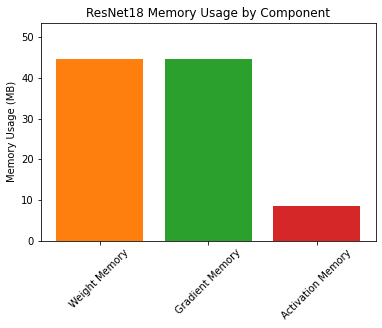

In [5]:

colors = ['#ff7f0e', '#2ca02c', '#d62728']

# 막대 그래프로 시각화
fig, ax = plt.subplots()
ax.bar(memory_usage.keys(), memory_usage.values(), color=colors)

ax.set_ylabel('Memory Usage (MB)')
ax.set_title('ResNet18 Memory Usage by Component')
ax.set_ylim(0, max(memory_usage.values()) * 1.2)  # 상단 여백 추가

save_path = 'fig_memory_footprint.png'

plt.xticks(rotation=45)  # x축 레이블 회전
plt.savefig(save_path, bbox_inches='tight')
plt.show()